 Hyperparameter Tuning of a Deep MLP on the MNIST Dataset Using Keras Tuner

 Import Required Libraries

In [29]:
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import kerastuner as kt
import matplotlib.pyplot as plt



<ipython-input-29-6114e9e2bff3>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Load Mnist Dataset

In [30]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target


Preprocess the data

In [31]:
# Preprocess the data
X = X / 255.0  # Normalize pixel values to [0, 1]
y = to_categorical(y.astype(int))  # One-hot encode labels



In [32]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Define the Model Building Function for Hyperparameter Tuning


In [36]:
# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Define the number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, default=2)
 # Add hidden layers with variable number of units
    for i in range(num_layers):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))  # 10 output classes for MNIST
 # Hyperparameter for learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



Initialize Keras Tuner for Hyperparameter Optimization

In [38]:
# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Maximum number of trials to search
    executions_per_trial=3,
    directory='kt_dir',
    project_name='mnist_tuning'
)
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)



Trial 10 Complete [00h 03m 03s]
val_accuracy: 0.9581190546353658

Best val_accuracy So Far: 0.9793571432431539
Total elapsed time: 01h 12m 07s


In [39]:
# Get the best hyperparameters from the tuner
best_hp = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:", best_hp.values)

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hp)

# Fetch batch_size from the best hyperparameters using dictionary indexing
batch_size = best_hp['batch_size'] if 'batch_size' in best_hp else 32

# Train the model using the best hyperparameters
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


Best hyperparameters: {'num_layers': 2, 'units_0': 192, 'units_1': 480, 'learning_rate': 0.00047508822661301836}
Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8710 - loss: 0.4482 - val_accuracy: 0.9538 - val_loss: 0.1517
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9686 - loss: 0.1023 - val_accuracy: 0.9666 - val_loss: 0.1078
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9807 - loss: 0.0625 - val_accuracy: 0.9724 - val_loss: 0.0904
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9851 - loss: 0.0447 - val_accuracy: 0.9751 - val_loss: 0.0870
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9899 - loss: 0.0313 - val_accuracy: 0.9771 - val_loss: 0.0834
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9927 - loss: 0.0239 - val_accuracy: 0.9749 - val_loss: 0.0900
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9936 - loss: 0.0192 - val_accura

Plot Learning Curves

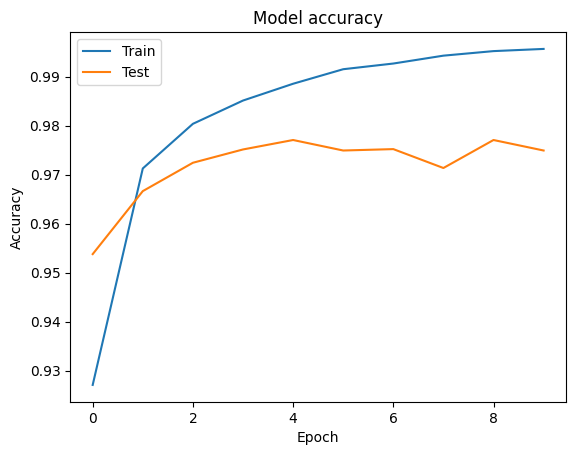

In [40]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


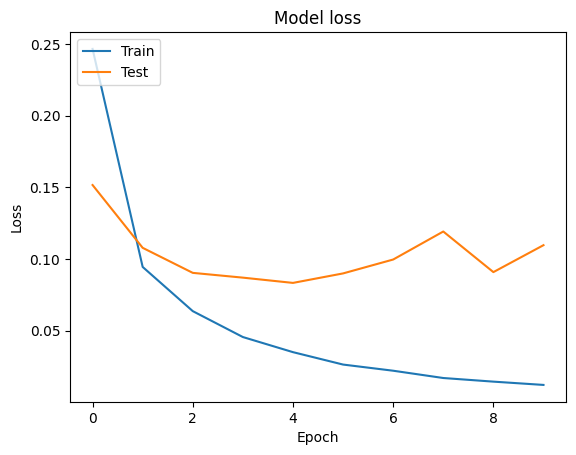

Best number of layers: 2
Best units in each layer: [192, 480]
Best learning rate: 0.00047508822661301836


In [41]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Summary of best hyperparameters
print(f"Best number of layers: {best_hp['num_layers']}")
print(f"Best units in each layer: {[best_hp[f'units_{i}'] for i in range(best_hp['num_layers'])]}")
print(f"Best learning rate: {best_hp['learning_rate']}")

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>